# Operator Inference Example for Energy-Preserving Burger's Equation

## Packages

In [1]:
using DataFrames
using FileIO
using JLD2
using LinearAlgebra
using NaNStatistics
using Plots
using ProgressMeter
using Random
using SparseArrays
using Statistics

## Initial Setup

In [2]:
include("../src/model/Burgers.jl")
include("../src/LiftAndLearn.jl")
const LnL = LiftAndLearn

┌ Warning: Replacing docs for `Main.LiftAndLearn.F2Hs :: Tuple{Any}` in module `Main.LiftAndLearn`
└ @ Base.Docs docs\Docs.jl:240


Main.LiftAndLearn

In [10]:
burger = Burgers(
    [0.0, 1.0], [0.0, 1.0], [0.05, 0.15],
    2^(-7), 1e-4, 10, "periodic"
);
burger.IC = sin.(2 * pi * burger.x)
# ic_a = range(0.8, 1.2, 10);  # coefficient that changes the initial condition for training data
ic_a = 1.0
;

## Least Squares Solution with multiple/single ICs and multiple $\mu$ values

In [11]:
num_ICs = length(ic_a)
rmax = 15
Vr_all = Vector{Matrix}(undef, 10)
op_inf_all = Vector{LnL.operators}(undef, 10)

options = LnL.OpInf_options(
    reproject=false,
    is_quad=true,
    has_control=false,
    has_output=false,
    N=1,
    Δt=1e-4,
    deriv_type="SI",
    which_quad_term="F",
    LS_pinv_tol = 1e-7,            # tolerance for pseudo-inverse
    # λ_LS = 0.02                    # regularization for least squares
)

DS = 100

# Error Values 
k = 1
proj_err = zeros(rmax - k, burger.Pdim)
intru_state_err = zeros(rmax - k, burger.Pdim)
opinf_state_err = zeros(rmax - k, burger.Pdim)

println("[INFO] Compute inferred and intrusive operators and calculate the errors")
@showprogress for i in 1:length(burger.μs)
    μ = burger.μs[i]

    # Create testing data
    A, F = burger.generateEPmatrix(burger, μ)
    Xtest = burger.semiImplicitEuler(A, F, burger.t, burger.IC)
    op_burger = LnL.operators(A=A, F=F)

    # training data for inferred dynamical models
    Xall = Vector{Matrix{Float64}}(undef, num_ICs)
    Xdotall = Vector{Matrix{Float64}}(undef, num_ICs)
    for j in 1:num_ICs
        states = burger.semiImplicitEuler(A, F, burger.t, ic_a[j] .* burger.IC)
        foo = states[:, 2:end]
        Xall[j] = foo[:, 1:DS:end]
        bar = (states[:, 2:end] - states[:, 1:end-1]) / burger.Δt
        Xdotall[j] = bar[:, 1:DS:end]
    end
    X = reduce(hcat, Xall)
    R = reduce(hcat, Xdotall)
    
    U = zeros(1,1)  # when no inputs define input as a 0 matrix
    Y = zeros(1,1)  # when no outputs define the output as a 0 matrix

    # compute the POD basis from the training data
    tmp = svd(X)
    Vrmax = tmp.U[:, 1:rmax]
    Vr_all[i] = Vrmax

    # Compute the values for the intrusive model from the basis of the training data
    op_int = LnL.intrusiveMR(op_burger, Vrmax, options)

    # Compute the inferred operators from the training data
    if options.reproject 
        op_inf = LnL.inferOp(X, U, Y, Vrmax, op_burger, options)  # Using Reprojection
    else
        op_inf = LnL.inferOp(X, U, Y, Vrmax, Vrmax' * R, options)
    end
    op_inf_all[i] = op_inf

    for j = 1+k:rmax
        Vr = Vrmax[:, 1:j]  # basis

        # Integrate the intrusive model
        Fint_extract = LnL.extractF(op_int.F, j)
        Xint = burger.semiImplicitEuler(op_int.A[1:j, 1:j], Fint_extract, burger.t, Vr' * burger.IC) # <- use F

        # Integrate the inferred model
        Finf_extract = LnL.extractF(op_inf.F, j)
        Xinf = burger.semiImplicitEuler(op_inf.A[1:j, 1:j], Finf_extract, burger.t, Vr' * burger.IC)  # <- use F

        # error values
        proj_err[j-k, i] = LnL.compProjError(Xtest, Vr)
        intru_state_err[j-k, i] = LnL.compStateError(Xtest, Xint, Vr)
        opinf_state_err[j-k, i] = LnL.compStateError(Xtest, Xinf, Vr)
    end
end


[INFO] Compute inferred and intrusive operators and calculate the errors

┌ Warning: Rank difficient, rank = 16, tol = 8.642732010227881e-8.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\learn.jl:87


┌ Warning: Rank difficient, rank = 16, tol = 7.065378665326094e-8.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\learn.jl:87


Progress:  20%|█████████                                |  ETA: 0:08:09

┌ Warning: Rank difficient, rank = 16, tol = 6.192494456916841e-8.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\learn.jl:87


Progress:  30%|█████████████                            |  ETA: 0:07:08

┌ Warning: Rank difficient, rank = 16, tol = 5.726709795857321e-8.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\learn.jl:87


Progress:  40%|█████████████████                        |  ETA: 0:06:05

┌ Warning: Rank difficient, rank = 16, tol = 5.422415435513079e-8.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\learn.jl:87


Progress:  50%|█████████████████████                    |  ETA: 0:05:05

┌ Warning: Rank difficient, rank = 16, tol = 5.123244783733762e-8.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\learn.jl:87


Progress:  60%|█████████████████████████                |  ETA: 0:04:04

┌ Warning: Rank difficient, rank = 16, tol = 4.749856957236655e-8.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\learn.jl:87


Progress:  70%|█████████████████████████████            |  ETA: 0:03:02

┌ Warning: Rank difficient, rank = 16, tol = 4.278456699586809e-8.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\learn.jl:87


Progress:  80%|█████████████████████████████████        |  ETA: 0:02:01

┌ Warning: Rank difficient, rank = 15, tol = 9.567660083376585e-8.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\learn.jl:87


Progress:  90%|█████████████████████████████████████    |  ETA: 0:01:00

┌ Warning: Rank difficient, rank = 15, tol = 8.036573455500953e-8.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\learn.jl:87


Progress: 100%|█████████████████████████████████████████| Time: 0:09:59


## Results

In [12]:
proj_err_avg = nanmean(proj_err, dims=2)
intru_state_err_avg = nanmean(intru_state_err, dims=2)
opinf_state_err_avg = nanmean(opinf_state_err, dims=2)

df = DataFrame(
    order=1+k:rmax,
    projection_err=vec(proj_err_avg),
    intrusive_state_err=vec(intru_state_err_avg),
    inferred_state_err=vec(opinf_state_err_avg),
)

Row,order,projection_err,intrusive_state_err,inferred_state_err
,Int64,Float64,Float64,Float64
1,2,0.00103268,0.00104933,0.00105198
2,3,0.000113193,0.000113504,0.000148502
3,4,3.83329e-5,4.03018e-5,0.000104257
4,5,9.93785e-6,1.00642e-5,9.77839e-5
5,6,1.55653e-6,1.769e-6,9.75331e-5
6,7,9.22716e-7,1.09463e-6,9.76568e-5
7,8,2.95624e-7,4.5068e-7,9.77115e-5
8,9,2.52563e-7,3.96107e-7,9.76924e-5
9,10,1.53964e-7,2.0696e-7,9.77477e-5


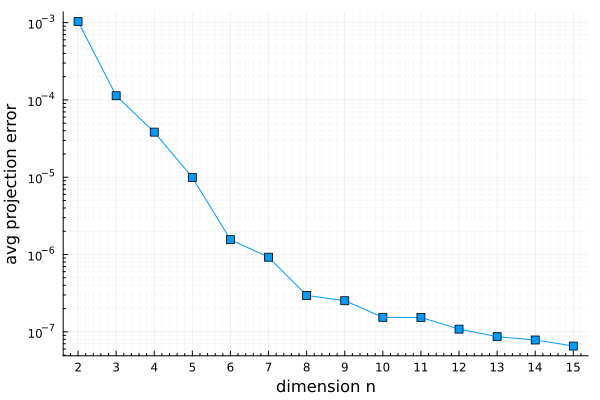

In [13]:
# Projection error
plot(df.order, df.projection_err, marker=(:rect))
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=false)
tmp = log10.(df.projection_err)
yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(df.order)
xlabel!("dimension n")
ylabel!("avg projection error")

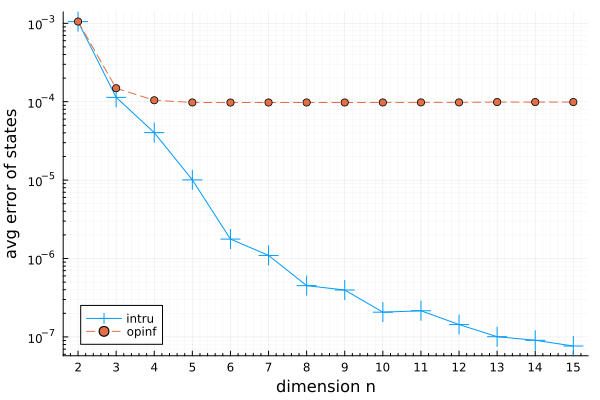

In [14]:
# State errors
plot(df.order, df.intrusive_state_err, marker=(:cross, 10), label="intru")
plot!(df.order, df.inferred_state_err, marker=(:circle), ls=:dash, label="opinf")
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=:bottomleft)
tmp = log10.(df.intrusive_state_err)
yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(df.order)
xlabel!("dimension n")
ylabel!("avg error of states")

In [15]:
DataFrame(opinf_state_err, :auto)

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0015164,0.00137211,0.00124828,0.00114127,0.00104818,0.000966709,0.000895017,0.000831608,0.000775232,0.000724962
2,0.00015803,0.000154551,0.00015189,0.000149791,0.000148086,0.000146663,0.000145452,0.000144409,0.000143526,0.000142624
3,0.000117661,0.000112423,0.000108535,0.000105555,0.000103231,0.000101398,9.99456e-5,9.87959e-5,9.79229e-5,9.70982e-5
4,0.000101056,9.99736e-5,9.9064e-5,9.83049e-5,9.76808e-5,9.71725e-5,9.67459e-5,9.63538e-5,9.58844e-5,9.56029e-5
5,0.000101156,9.99108e-5,9.89237e-5,9.8112e-5,9.74274e-5,9.68387e-5,9.63247e-5,9.58703e-5,9.55447e-5,9.52228e-5
6,0.000101279,0.000100072,9.90721e-5,9.82331e-5,9.75205e-5,9.68429e-5,9.63991e-5,9.59568e-5,9.56707e-5,9.55213e-5
7,0.000101258,0.000100056,9.90592e-5,9.82226e-5,9.75129e-5,9.69055e-5,9.63815e-5,9.59265e-5,9.61247e-5,9.56676e-5
8,0.000101436,0.000100293,9.92343e-5,9.82988e-5,9.7546e-5,9.69242e-5,9.63965e-5,9.59412e-5,9.56061e-5,9.52473e-5
9,0.0001019,0.000100389,9.922e-5,9.83023e-5,9.75559e-5,9.69325e-5,9.64028e-5,9.59464e-5,9.55989e-5,9.52291e-5


## Least Squares Solution with single ICs and multiple $\mu$ values

In [10]:
@info "Settings for the Burgers equation"
ic_a = 1.0;  # coefficient that changes the initial condition for training data

num_ICs = length(ic_a)
rmax = 15

options = LnL.OpInf_options(
    reproject=false,
    is_quad=true,
    has_control=false,
    has_output=false,
    N=1,
    Δt=1e-4,
    deriv_type="SI",
    which_quad_term="F"
)

# Error Values 
k = 0
proj_err = zeros(rmax - k, 1)
intru_state_err = zeros(rmax - k, 1)
opinf_state_err = zeros(rmax - k, 1)

μ = 0.1
;

┌ Info: Settings for the Burgers equation
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\06_ep-burgers_OpInf_LS.ipynb:1


In [5]:
@info "Generate testing data"
# Create testing data
A, F = burger.generateEPmatrix(burger, μ)
Xtest = burger.semiImplicitEuler(A, F, burger.t, burger.IC)
op_burger = LnL.operators(A=A, F=F)
;

┌ Info: Generate testing data
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\06_ep-burgers_OpInf_LS.ipynb:1


In [7]:
@info "Generate training data"
# training data for inferred dynamical models
Xall = Vector{Matrix{Float64}}(undef, num_ICs)
Xdotall = Vector{Matrix{Float64}}(undef, num_ICs)
for j in 1:num_ICs
    states = burger.semiImplicitEuler(A, F, burger.t, ic_a[j] .* burger.IC)
    Xall[j] = states[:, 2:end]
    Xdotall[j] = (states[:, 2:end] - states[:, 1:end-1]) / burger.Δt
end
X = reduce(hcat, Xall)
R = reduce(hcat, Xdotall)

U = zeros(1,1)  # when no inputs define input as a 0 matrix
Y = zeros(1,1)  # when no outputs define the output as a 0 matrix

# compute the POD basis from the training data
tmp = svd(X)
Vrmax = tmp.U[:, 1:rmax]
;

┌ Info: Generate training data
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\06_ep-burgers_OpInf_LS.ipynb:1


In [11]:
@info "Compute the values for the intrusive model from the basis of the training data"
# Compute the values for the intrusive model from the basis of the training data
op_int = LnL.intrusiveMR(op_burger, Vrmax, options)
;

┌ Info: Compute the values for the intrusive model from the basis of the training data
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\06_ep-burgers_OpInf_LS.ipynb:1


In [21]:
@info "Compute the inferred operators from the training data"
# Compute the inferred operators from the training data
if options.reproject 
    op_inf_LS = LnL.inferOp(X, U, Y, Vrmax, op_burger, options)  # Using Reprojection
else
    op_inf_LS = LnL.inferOp(X, U, Y, Vrmax, Vrmax' * R, options)
end
;

┌ Info: Compute the inferred operators from the training data
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\06_ep-burgers_OpInf_LS.ipynb:1
┌ Warning: Rank difficient, rank = 26, tol = 7.503654386818286e-7.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\learn.jl:87


In [11]:
@info "Integrate the intrusive and inferred models and compute the errors"
for j = 1+k:rmax
    Vr = Vrmax[:, 1:j]  # basis

    # Integrate the intrusive model
    Fint_extract = LnL.extractF(op_int.F, j)
    Xint = burger.semiImplicitEuler(op_int.A[1:j, 1:j], Fint_extract, burger.t, Vr' * burger.IC) # <- use F

    # Integrate the inferred model
    Finf_extract = LnL.extractF(op_inf_LS.F, j)
    Xinf = burger.semiImplicitEuler(op_inf_LS.A[1:j, 1:j], Finf_extract, burger.t, Vr' * burger.IC)  # <- use F

    # error values
    proj_err[j-k] = LnL.compProjError(Xtest, Vr)
    intru_state_err[j-k] = LnL.compStateError(Xtest, Xint, Vr)
    opinf_state_err[j-k] = LnL.compStateError(Xtest, Xinf, Vr)
end
;

┌ Info: Integrate the intrusive and inferred models and compute the errors
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\06_ep-burgers_OpInf_LS.ipynb:10


In [22]:
@debug "Save the inferred operator"
@save "data/ep-burgers_LS_op.jld2" op_inf_LS op_int 

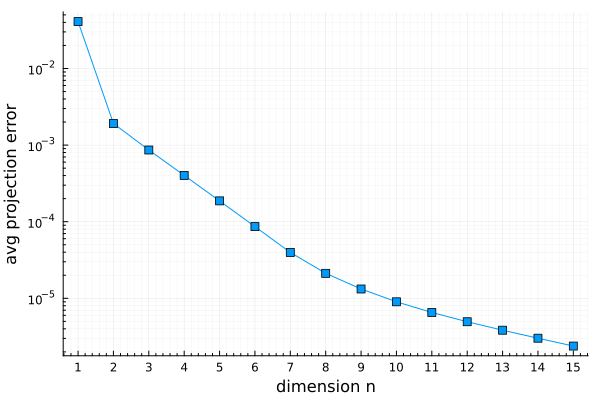

In [13]:
# Projection error
plot(1+k:rmax, proj_err, marker=(:rect))
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=false)
tmp = log10.(proj_err)
yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(1+k:rmax)
xlabel!("dimension n")
ylabel!("avg projection error")

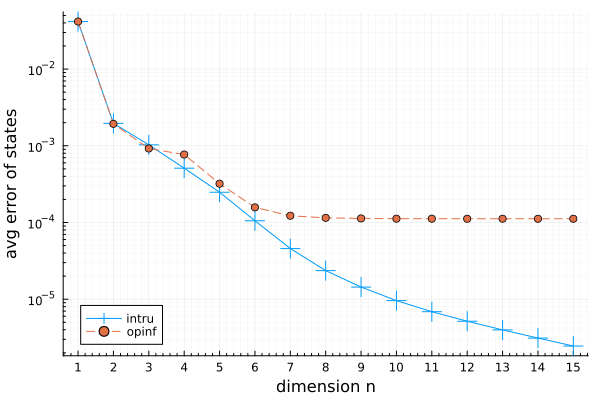

In [14]:
# State errors
plot(1+k:rmax, intru_state_err, marker=(:cross, 10), label="intru")
plot!(1+k:rmax, opinf_state_err, marker=(:circle), ls=:dash, label="opinf")
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=:bottomleft)
yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(1+k:rmax)
xlabel!("dimension n")
ylabel!("avg error of states")